In [1]:
# расскоментируйте код ниже, чтобы установить все зависимости
# !pip install -q \
#     pyarrow==12.0.1 \
#     polars==0.18.6 \
#     pandas==2.0.3 \
#     lightfm==1.17 \
#     optuna==3.3.0 \
#     tqdm==4.65.0 \
#     scipy==1.10.1 \
#     numpy==1.24.3 \
#     faiss-cpu==1.7.4 \
#     implicit==0.7.0

In [3]:
# раскоментируйте код ниже, чтобы скачать данные
# !wget -q https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip -q ml-1m.zip

In [1]:
import optuna
import random

import polars as pl
import pandas as pd
import numpy as np

from typing import List
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

import implicit
import faiss
from lightfm import LightFM

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Как и раньше, будем работать с датаестом movielens, где есть информация об явной реакции для фильмов и сериалов

In [2]:
ratings = pd.read_csv(
    'ml-1m/ratings.dat', delimiter='::', header=None, 
    names=['user_id', 'item_id', 'rating', 'timestamp'], 
    engine='python'
)
ratings = pl.from_pandas(ratings).filter(pl.col('rating') >= 4)
ratings

user_id,item_id,rating,timestamp
i64,i64,i64,i64
1,1193,5,978300760
1,3408,4,978300275
1,2355,5,978824291
1,1287,5,978302039
1,2804,5,978300719
1,594,4,978302268
1,919,4,978301368
1,595,5,978824268
1,938,4,978301752


In [3]:
ratings['user_id'].n_unique(), ratings['item_id'].n_unique()

(6038, 3533)

In [4]:
grouped_df = (
    ratings
    .groupby('user_id')
    .agg([
        pl.col('item_id').apply(lambda x: x[:-3]).alias('train_item_ids'),
        pl.col('rating').apply(lambda x: x[:-3]).alias('train_ratings'),
        pl.col('item_id').apply(lambda x: x[-3:]).alias('test_item_ids'),
        pl.col('rating').apply(lambda x: x[-3:]).alias('test_ratings'),
    ])
)
grouped_df

user_id,train_item_ids,train_ratings,test_item_ids,test_ratings
i64,list[i64],list[i64],list[i64],list[i64]
3344,"[1249, 1250, … 2028]","[4, 5, … 4]","[1086, 1230, 1233]","[4, 5, 4]"
3944,"[1259, 593, … 1213]","[4, 4, … 5]","[1221, 1097, 1246]","[4, 4, 4]"
5170,"[3000, 2064, … 2791]","[5, 5, … 5]","[1060, 541, 1079]","[4, 4, 4]"
2722,"[593, 2622, … 3753]","[4, 4, … 5]","[1214, 1215, 541]","[4, 4, 5]"
1628,"[2987, 3793, … 2985]","[5, 4, … 4]","[1246, 2986, 1247]","[4, 4, 4]"
5600,"[585, 587, … 1080]","[4, 5, … 5]","[1081, 1082, 1095]","[5, 4, 4]"
5630,"[2058, 588, … 556]","[4, 4, … 5]","[1092, 1094, 1095]","[4, 4, 5]"
526,"[589, 6, … 2028]","[4, 4, … 5]","[1089, 1240, 1242]","[5, 4, 4]"
3592,"[3789, 1250, … 1096]","[4, 4, … 5]","[1097, 1244, 1247]","[4, 4, 5]"


In [5]:
median_seq_len = int(grouped_df['train_item_ids'].apply(len).median())
print(f"средняя длина сессии {median_seq_len}")

средняя длина сессии 55


In [6]:
# соберем строчки для разреженной матрицы
rows = []
cols = []
values = []

for user_id, train_item_ids, train_ratings in grouped_df.select(
    'user_id', 'train_item_ids', 'train_ratings'
).rows():
    rows.extend([user_id] * len(train_item_ids))
    cols.extend(train_item_ids)
    values.extend(train_ratings)

user_item_data = sp.csr_matrix((values, (rows, cols)), dtype=np.float32)
user_item_data

<6041x3953 sparse matrix of type '<class 'numpy.float32'>'
	with 557171 stored elements in Compressed Sparse Row format>

In [7]:
TOP_K = 10


def user_hitrate(y_relevant: List[str], y_recs: List[str], k: int = TOP_K) -> int:
    return int(len(set(y_relevant).intersection(y_recs[:k])) > 0)

In [8]:
RANDOM_STATE = 42

def set_seed():
    random.seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    
    
def get_recommendations(user_embs: np.array, item_embs: np.array, k: int = TOP_K):
    # строим индекс объектов
    index = faiss.IndexFlatIP(item_embs.shape[1])
    index.add(item_embs)

    # строим рекомендации с помощью dot-product расстояния
    return index.search(user_embs, k)

def evaluate_model(user_embs: np.array, item_embs: np.array):
    # строим рекомендации с запасом, так как включена фильтрация уже просмотренного
    # и может не остаться рекомендаций после нее
    _, recs = get_recommendations(user_embs, item_embs, TOP_K + median_seq_len)
    
    # посчитаем метрики качества рекомендаций
    hitrate_list = []
    for user_id, user_history, y_rel in grouped_df.select('user_id', 'train_item_ids', 'test_item_ids').rows():
        y_rec = [
            item_id
            for item_id in recs[user_id]
            # фильтруем уже просмотренное
            if item_id not in user_history
        ]
        hitrate_list.append(user_hitrate(y_rel, y_rec))
    return np.mean(hitrate_list)

## SVD

У такого алгоритма есть параметр `k` – количество главных компонент, которые можно интерпретировать как размерность скрытого пространства модели

Попробуем провести эксперимент с зависимостью от того, как хорошо алгоритм SVD восстанавливает матрицу рейтингов и качеством самих рекомендаций. Для этого будем использовать реализацию SVD алгоритма из библиотеки [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html)

100%|██████████| 20/20 [01:35<00:00,  4.80s/it]


Оптимальное k = 56 (Hitrate@10 = 0.234)


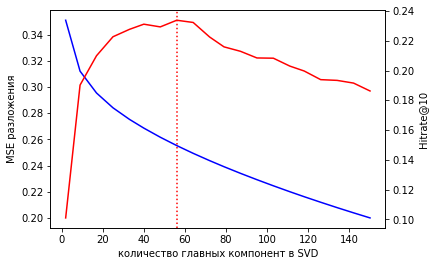

In [9]:
k_range = []
mse_list = []
mean_hitrate_list = []

for k in tqdm(np.linspace(2, 150, 20)):
    k = int(k)
    k_range.append(k)
    
    # выполним алгоритм SVD с заданным числом главных компонент k
    U, S, V = sp.linalg.svds(user_item_data, k=k, random_state=RANDOM_STATE)
    
    # посчитаем ошибку MSE восстановленной матрицы с помощью SVD разложения
    mse = np.power(U @ np.diag(S) @ V - user_item_data, 2).mean()
    mse_list.append(mse)

    # построим рекомендации с помощью cosine knn index
    user_embs, item_embs = U @ np.diag(S), V.T
    mean_hitrate = evaluate_model(
        user_embs,
        item_embs,
    )
    mean_hitrate_list.append(mean_hitrate)
    
k_optimal = k_range[np.argmax(mean_hitrate_list)]
print(f'Оптимальное k = {k_optimal} (Hitrate@{TOP_K} = {np.max(mean_hitrate_list):.3f})')

fig, ax1 = plt.subplots()
ax1.plot(k_range, mse_list, c='b')
ax1.set_xlabel('количество главных компонент в SVD')
ax1.set_ylabel('MSE разложения')

ax2 = ax1.twinx()

ax2.plot(k_range, mean_hitrate_list, c='r')
ax2.set_ylabel(f'Hitrate@{TOP_K}')
ax2.axvline(x=k_optimal, c='r', linestyle=':')
plt.show()

In [10]:
U.shape, S.shape, V.shape

((6041, 150), (150,), (150, 3953))

## ALS, BPR (из библиотеки implicit)

Гиперпараметры могут сильно влиять на метрики качества, поэтому стоит их подобрать с помощью библиотеки [optuna](https://optuna.org/)

Для алгоритма [ALS](https://benfred.github.io/implicit/api/models/cpu/als.html) рассмотрим следующие параметры:
- `factors` – размерность эмбеддингов
- `iterations` – сколько итераций будет обучаться алгоритм
- `alpha` – параметр implicitALS, учитывающий оценку в разреженной матрице как вес
- `regularization` – параметр регуляризации эмбеддингов

In [11]:
set_seed()
als_model = implicit.als.AlternatingLeastSquares(
    factors=64,
    iterations=30,
    calculate_training_loss=True,
    random_state=RANDOM_STATE,
    regularization=0.05
)
als_model.fit(user_item_data)

mean_hitrate = evaluate_model(
    als_model.user_factors,
    als_model.item_factors,
)
print(f'Hitrate@{TOP_K} = {mean_hitrate}')

100%|██████████| 30/30 [00:37<00:00,  1.24s/it, loss=0.0313]


Hitrate@10 = 0.2101689301093077


In [12]:
def objective(trial):
    factors = trial.suggest_int('factors', 8, 128)
    iterations = trial.suggest_int('iterations', 5, 30)
    alpha = trial.suggest_float('alpha', 0.1, 5.0)
    regularization = trial.suggest_float('regularization', 1e-3, 1.0)
        
    print({
        'factors': factors,
        'iterations': iterations,
        'alpha': alpha,
        'regularization': regularization,
    })
    
    set_seed()
    als_model = implicit.als.AlternatingLeastSquares(
        factors=factors,
        iterations=iterations,
        random_state=RANDOM_STATE,
        alpha=alpha,
        regularization=regularization
    )
    als_model.fit(user_item_data)
    
    mean_hitrate = evaluate_model(
        als_model.user_factors,
        als_model.item_factors,
    )
    
    print(f'Hitrate@{TOP_K} = {mean_hitrate}')
    return mean_hitrate
    
# для запуска optuna нужно определить функцию и направление (минимизация/максимизация)
# в данном случае мы максимизируем метрику Hitrate@10
study = optuna.create_study(directions=('maximize',))
# запустим процесс подбора гиперпараметров
study.optimize(objective, n_trials=25)

# лучшие параметры будут храниться тут
study.best_params

[I 2024-08-03 14:27:35,449] A new study created in memory with name: no-name-8ca597bc-ff0f-413e-93aa-79275e624f49


{'factors': 93, 'iterations': 9, 'alpha': 1.5275248750495805, 'regularization': 0.5303277209122342}


100%|██████████| 9/9 [00:11<00:00,  1.32s/it]
[I 2024-08-03 14:27:48,330] Trial 0 finished with value: 0.1990725405763498 and parameters: {'factors': 93, 'iterations': 9, 'alpha': 1.5275248750495805, 'regularization': 0.5303277209122342}. Best is trial 0 with value: 0.1990725405763498.


Hitrate@10 = 0.1990725405763498
{'factors': 14, 'iterations': 25, 'alpha': 4.518134133828279, 'regularization': 0.3613819666658347}


100%|██████████| 25/25 [00:17<00:00,  1.45it/s]
[I 2024-08-03 14:28:06,570] Trial 1 finished with value: 0.15617754223252733 and parameters: {'factors': 14, 'iterations': 25, 'alpha': 4.518134133828279, 'regularization': 0.3613819666658347}. Best is trial 0 with value: 0.1990725405763498.


Hitrate@10 = 0.15617754223252733
{'factors': 34, 'iterations': 28, 'alpha': 3.4120951683100844, 'regularization': 0.8313115226167381}


100%|██████████| 28/28 [00:22<00:00,  1.25it/s]
[I 2024-08-03 14:28:30,047] Trial 2 finished with value: 0.17919841006955944 and parameters: {'factors': 34, 'iterations': 28, 'alpha': 3.4120951683100844, 'regularization': 0.8313115226167381}. Best is trial 0 with value: 0.1990725405763498.


Hitrate@10 = 0.17919841006955944
{'factors': 35, 'iterations': 7, 'alpha': 2.8707775721076345, 'regularization': 0.018970828026545324}


100%|██████████| 7/7 [00:06<00:00,  1.12it/s]
[I 2024-08-03 14:28:37,266] Trial 3 finished with value: 0.18052335210334547 and parameters: {'factors': 35, 'iterations': 7, 'alpha': 2.8707775721076345, 'regularization': 0.018970828026545324}. Best is trial 0 with value: 0.1990725405763498.


Hitrate@10 = 0.18052335210334547
{'factors': 20, 'iterations': 19, 'alpha': 3.679161962035861, 'regularization': 0.7417174273115966}


100%|██████████| 19/19 [00:13<00:00,  1.40it/s]
[I 2024-08-03 14:28:51,865] Trial 4 finished with value: 0.16859887379927127 and parameters: {'factors': 20, 'iterations': 19, 'alpha': 3.679161962035861, 'regularization': 0.7417174273115966}. Best is trial 0 with value: 0.1990725405763498.


Hitrate@10 = 0.16859887379927127
{'factors': 110, 'iterations': 6, 'alpha': 3.5984974467172677, 'regularization': 0.3802806517473081}


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]
[I 2024-08-03 14:29:00,340] Trial 5 finished with value: 0.1899635640940709 and parameters: {'factors': 110, 'iterations': 6, 'alpha': 3.5984974467172677, 'regularization': 0.3802806517473081}. Best is trial 0 with value: 0.1990725405763498.


Hitrate@10 = 0.1899635640940709
{'factors': 27, 'iterations': 12, 'alpha': 2.1436005620342367, 'regularization': 0.5213055646621576}


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]
[I 2024-08-03 14:29:11,538] Trial 6 finished with value: 0.18482941371315004 and parameters: {'factors': 27, 'iterations': 12, 'alpha': 2.1436005620342367, 'regularization': 0.5213055646621576}. Best is trial 0 with value: 0.1990725405763498.


Hitrate@10 = 0.18482941371315004
{'factors': 86, 'iterations': 10, 'alpha': 1.1393478806500357, 'regularization': 0.29239849811510005}


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]
[I 2024-08-03 14:29:24,235] Trial 7 finished with value: 0.20271613116926135 and parameters: {'factors': 86, 'iterations': 10, 'alpha': 1.1393478806500357, 'regularization': 0.29239849811510005}. Best is trial 7 with value: 0.20271613116926135.


Hitrate@10 = 0.20271613116926135
{'factors': 26, 'iterations': 6, 'alpha': 4.368788197643686, 'regularization': 0.06388848219071597}


100%|██████████| 6/6 [00:05<00:00,  1.12it/s]
[I 2024-08-03 14:29:30,565] Trial 8 finished with value: 0.17952964557800596 and parameters: {'factors': 26, 'iterations': 6, 'alpha': 4.368788197643686, 'regularization': 0.06388848219071597}. Best is trial 7 with value: 0.20271613116926135.


Hitrate@10 = 0.17952964557800596
{'factors': 11, 'iterations': 16, 'alpha': 1.6972368269000957, 'regularization': 0.8904799100401787}


100%|██████████| 16/16 [00:09<00:00,  1.62it/s]
[I 2024-08-03 14:29:41,540] Trial 9 finished with value: 0.16164292812189468 and parameters: {'factors': 11, 'iterations': 16, 'alpha': 1.6972368269000957, 'regularization': 0.8904799100401787}. Best is trial 7 with value: 0.20271613116926135.


Hitrate@10 = 0.16164292812189468
{'factors': 68, 'iterations': 15, 'alpha': 0.3134607834275458, 'regularization': 0.2130633219051582}


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]
[I 2024-08-03 14:29:57,063] Trial 10 finished with value: 0.22789002981119577 and parameters: {'factors': 68, 'iterations': 15, 'alpha': 0.3134607834275458, 'regularization': 0.2130633219051582}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.22789002981119577
{'factors': 72, 'iterations': 16, 'alpha': 0.21941405387268686, 'regularization': 0.1986146866146279}


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]
[I 2024-08-03 14:30:15,110] Trial 11 finished with value: 0.2277244120569725 and parameters: {'factors': 72, 'iterations': 16, 'alpha': 0.21941405387268686, 'regularization': 0.1986146866146279}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.2277244120569725
{'factors': 61, 'iterations': 18, 'alpha': 0.13322104475518076, 'regularization': 0.20283585653314432}


100%|██████████| 18/18 [00:22<00:00,  1.28s/it]
[I 2024-08-03 14:30:39,014] Trial 12 finished with value: 0.22126531964226565 and parameters: {'factors': 61, 'iterations': 18, 'alpha': 0.13322104475518076, 'regularization': 0.20283585653314432}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.22126531964226565
{'factors': 60, 'iterations': 14, 'alpha': 0.2698686191930368, 'regularization': 0.1510160617415736}


100%|██████████| 14/14 [00:15<00:00,  1.08s/it]
[I 2024-08-03 14:30:55,150] Trial 13 finished with value: 0.22524014574362372 and parameters: {'factors': 60, 'iterations': 14, 'alpha': 0.2698686191930368, 'regularization': 0.1510160617415736}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.22524014574362372
{'factors': 77, 'iterations': 22, 'alpha': 0.7999868573856845, 'regularization': 0.1301450980959155}


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]
[I 2024-08-03 14:31:19,417] Trial 14 finished with value: 0.2101689301093077 and parameters: {'factors': 77, 'iterations': 22, 'alpha': 0.7999868573856845, 'regularization': 0.1301450980959155}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.2101689301093077
{'factors': 49, 'iterations': 21, 'alpha': 0.9035810070305702, 'regularization': 0.23484255695217357}


100%|██████████| 21/21 [00:22<00:00,  1.06s/it]
[I 2024-08-03 14:31:42,729] Trial 15 finished with value: 0.2081815170586287 and parameters: {'factors': 49, 'iterations': 21, 'alpha': 0.9035810070305702, 'regularization': 0.23484255695217357}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.2081815170586287
{'factors': 115, 'iterations': 15, 'alpha': 0.162090318055552, 'regularization': 0.021544772287524494}


100%|██████████| 15/15 [00:19<00:00,  1.31s/it]
[I 2024-08-03 14:32:03,481] Trial 16 finished with value: 0.20122557138125208 and parameters: {'factors': 115, 'iterations': 15, 'alpha': 0.162090318055552, 'regularization': 0.021544772287524494}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.20122557138125208
{'factors': 98, 'iterations': 12, 'alpha': 0.6443188679374471, 'regularization': 0.3817176685926669}


100%|██████████| 12/12 [00:14<00:00,  1.18s/it]
[I 2024-08-03 14:32:18,584] Trial 17 finished with value: 0.210997018880424 and parameters: {'factors': 98, 'iterations': 12, 'alpha': 0.6443188679374471, 'regularization': 0.3817176685926669}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.210997018880424
{'factors': 73, 'iterations': 22, 'alpha': 1.1323277597918062, 'regularization': 0.14091620821649292}


100%|██████████| 22/22 [00:23<00:00,  1.08s/it]
[I 2024-08-03 14:32:43,381] Trial 18 finished with value: 0.20420669095727062 and parameters: {'factors': 73, 'iterations': 22, 'alpha': 1.1323277597918062, 'regularization': 0.14091620821649292}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.20420669095727062
{'factors': 128, 'iterations': 19, 'alpha': 1.9689363374435764, 'regularization': 0.2768205405803755}


100%|██████████| 19/19 [00:22<00:00,  1.18s/it]
[I 2024-08-03 14:33:06,875] Trial 19 finished with value: 0.19046041735674063 and parameters: {'factors': 128, 'iterations': 19, 'alpha': 1.9689363374435764, 'regularization': 0.2768205405803755}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.19046041735674063
{'factors': 49, 'iterations': 12, 'alpha': 1.343291082850199, 'regularization': 0.4615566529087758}


100%|██████████| 12/12 [00:12<00:00,  1.08s/it]
[I 2024-08-03 14:33:20,847] Trial 20 finished with value: 0.1990725405763498 and parameters: {'factors': 49, 'iterations': 12, 'alpha': 1.343291082850199, 'regularization': 0.4615566529087758}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.1990725405763498
{'factors': 60, 'iterations': 15, 'alpha': 0.4590835723227142, 'regularization': 0.13931146957322466}


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]
[I 2024-08-03 14:33:39,258] Trial 21 finished with value: 0.2217621729049354 and parameters: {'factors': 60, 'iterations': 15, 'alpha': 0.4590835723227142, 'regularization': 0.13931146957322466}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.2217621729049354
{'factors': 49, 'iterations': 15, 'alpha': 0.4071887679688362, 'regularization': 0.19050124378137287}


100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
[I 2024-08-03 14:33:56,910] Trial 22 finished with value: 0.2214309373964889 and parameters: {'factors': 49, 'iterations': 15, 'alpha': 0.4071887679688362, 'regularization': 0.19050124378137287}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.2214309373964889
{'factors': 64, 'iterations': 13, 'alpha': 0.11134178588782495, 'regularization': 0.10772695425873824}


100%|██████████| 13/13 [00:12<00:00,  1.03it/s]
[I 2024-08-03 14:34:10,403] Trial 23 finished with value: 0.2176217290493541 and parameters: {'factors': 64, 'iterations': 13, 'alpha': 0.11134178588782495, 'regularization': 0.10772695425873824}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.2176217290493541
{'factors': 83, 'iterations': 17, 'alpha': 0.7437912115861935, 'regularization': 0.017600539283879196}


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]
[I 2024-08-03 14:34:29,006] Trial 24 finished with value: 0.2085127525670752 and parameters: {'factors': 83, 'iterations': 17, 'alpha': 0.7437912115861935, 'regularization': 0.017600539283879196}. Best is trial 10 with value: 0.22789002981119577.


Hitrate@10 = 0.2085127525670752


{'factors': 68,
 'iterations': 15,
 'alpha': 0.3134607834275458,
 'regularization': 0.2130633219051582}

In [13]:
als_model = implicit.als.AlternatingLeastSquares(
    random_state=RANDOM_STATE,
    **study.best_params
)
als_model.fit(user_item_data)

mean_hitrate = evaluate_model(
    als_model.user_factors,
    als_model.item_factors,
)
print(f'Hitrate@{TOP_K} = {mean_hitrate}')

100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Hitrate@10 = 0.22789002981119577


Дла алгоритма [BPR](https://benfred.github.io/implicit/api/models/cpu/bpr.html) рассмотрим следующие параметры:

- `factors` – размерность эмбеддингов
- `iterations` – сколько итераций будет обучаться алгоритм
- `learning_rate` – скорость обучения алгоритма градиентного спуска
- `regularization` – параметр регуляризации эмбеддингов

In [14]:
def objective(trial):
    factors = trial.suggest_int('factors', 8, 128)
    iterations = trial.suggest_int('iterations', 10, 100)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    regularization = trial.suggest_float('regularization', 1e-3, 1e-1)
        
    print({
        'factors': factors,
        'iterations': iterations,
        'learning_rate': learning_rate,
        'regularization': regularization,
    })
    
    set_seed()
    bpr_model = implicit.bpr.BayesianPersonalizedRanking(
        factors=factors,
        iterations=iterations,
        random_state=RANDOM_STATE,
        learning_rate=learning_rate,
        regularization=regularization
    )
    bpr_model.fit(user_item_data)
    
    mean_hitrate = evaluate_model(
        bpr_model.user_factors,
        bpr_model.item_factors,
    )
    print(f'Hitrate@{TOP_K} = {mean_hitrate}')
    return mean_hitrate
    
    
study = optuna.create_study(directions=('maximize',))
study.optimize(objective, n_trials=25)

study.best_params

[I 2024-08-03 14:35:20,675] A new study created in memory with name: no-name-5dbd08ed-5109-4bec-a83f-cd21f12a79f0


{'factors': 41, 'iterations': 69, 'learning_rate': 0.017108297276567735, 'regularization': 0.07150210759139948}


100%|██████████| 69/69 [00:08<00:00,  7.89it/s, train_auc=80.83%, skipped=20.87%]
[I 2024-08-03 14:35:30,438] Trial 0 finished with value: 0.1265319642265651 and parameters: {'factors': 41, 'iterations': 69, 'learning_rate': 0.017108297276567735, 'regularization': 0.07150210759139948}. Best is trial 0 with value: 0.1265319642265651.


Hitrate@10 = 0.1265319642265651
{'factors': 99, 'iterations': 52, 'learning_rate': 0.04521980424774215, 'regularization': 0.08294978235463951}


100%|██████████| 52/52 [00:09<00:00,  5.61it/s, train_auc=79.62%, skipped=20.98%]
[I 2024-08-03 14:35:40,890] Trial 1 finished with value: 0.13431599867505797 and parameters: {'factors': 99, 'iterations': 52, 'learning_rate': 0.04521980424774215, 'regularization': 0.08294978235463951}. Best is trial 1 with value: 0.13431599867505797.


Hitrate@10 = 0.13431599867505797
{'factors': 25, 'iterations': 26, 'learning_rate': 0.05015784908787041, 'regularization': 0.015675908077922483}


100%|██████████| 26/26 [00:03<00:00,  6.77it/s, train_auc=87.47%, skipped=20.95%]
[I 2024-08-03 14:35:45,706] Trial 2 finished with value: 0.15402451142762505 and parameters: {'factors': 25, 'iterations': 26, 'learning_rate': 0.05015784908787041, 'regularization': 0.015675908077922483}. Best is trial 2 with value: 0.15402451142762505.


Hitrate@10 = 0.15402451142762505
{'factors': 121, 'iterations': 53, 'learning_rate': 0.023689279288122034, 'regularization': 0.04338820551326974}


100%|██████████| 53/53 [00:10<00:00,  5.24it/s, train_auc=83.71%, skipped=20.81%]
[I 2024-08-03 14:35:56,826] Trial 3 finished with value: 0.1425968863862206 and parameters: {'factors': 121, 'iterations': 53, 'learning_rate': 0.023689279288122034, 'regularization': 0.04338820551326974}. Best is trial 2 with value: 0.15402451142762505.


Hitrate@10 = 0.1425968863862206
{'factors': 52, 'iterations': 88, 'learning_rate': 0.07749640581016046, 'regularization': 0.022101229119595705}


100%|██████████| 88/88 [00:11<00:00,  7.65it/s, train_auc=89.31%, skipped=20.91%]
[I 2024-08-03 14:36:09,288] Trial 4 finished with value: 0.14176879761510433 and parameters: {'factors': 52, 'iterations': 88, 'learning_rate': 0.07749640581016046, 'regularization': 0.022101229119595705}. Best is trial 2 with value: 0.15402451142762505.


Hitrate@10 = 0.14176879761510433
{'factors': 106, 'iterations': 54, 'learning_rate': 0.017412420465009, 'regularization': 0.040607991468377694}


100%|██████████| 54/54 [00:08<00:00,  6.25it/s, train_auc=83.51%, skipped=20.95%]
[I 2024-08-03 14:36:18,965] Trial 5 finished with value: 0.1488903610467042 and parameters: {'factors': 106, 'iterations': 54, 'learning_rate': 0.017412420465009, 'regularization': 0.040607991468377694}. Best is trial 2 with value: 0.15402451142762505.


Hitrate@10 = 0.1488903610467042
{'factors': 60, 'iterations': 18, 'learning_rate': 0.008288978447669437, 'regularization': 0.09205087603898664}


100%|██████████| 18/18 [00:02<00:00,  7.99it/s, train_auc=55.69%, skipped=21.03%]
[I 2024-08-03 14:36:22,208] Trial 6 finished with value: 0.0876117919841007 and parameters: {'factors': 60, 'iterations': 18, 'learning_rate': 0.008288978447669437, 'regularization': 0.09205087603898664}. Best is trial 2 with value: 0.15402451142762505.


Hitrate@10 = 0.0876117919841007
{'factors': 69, 'iterations': 67, 'learning_rate': 0.0599954999131854, 'regularization': 0.011229271984255575}


100%|██████████| 67/67 [00:09<00:00,  6.90it/s, train_auc=92.62%, skipped=20.98%]
[I 2024-08-03 14:36:32,977] Trial 7 finished with value: 0.15054653858893674 and parameters: {'factors': 69, 'iterations': 67, 'learning_rate': 0.0599954999131854, 'regularization': 0.011229271984255575}. Best is trial 2 with value: 0.15402451142762505.


Hitrate@10 = 0.15054653858893674
{'factors': 88, 'iterations': 27, 'learning_rate': 0.061030549412637906, 'regularization': 0.061910686116888394}


100%|██████████| 27/27 [00:04<00:00,  5.81it/s, train_auc=81.27%, skipped=20.88%]
[I 2024-08-03 14:36:38,627] Trial 8 finished with value: 0.11344816164292812 and parameters: {'factors': 88, 'iterations': 27, 'learning_rate': 0.061030549412637906, 'regularization': 0.061910686116888394}. Best is trial 2 with value: 0.15402451142762505.


Hitrate@10 = 0.11344816164292812
{'factors': 22, 'iterations': 63, 'learning_rate': 0.08925605486987014, 'regularization': 0.00501816463183758}


100%|██████████| 63/63 [00:06<00:00,  9.41it/s, train_auc=86.40%, skipped=20.98%]
[I 2024-08-03 14:36:46,282] Trial 9 finished with value: 0.10566412719443524 and parameters: {'factors': 22, 'iterations': 63, 'learning_rate': 0.08925605486987014, 'regularization': 0.00501816463183758}. Best is trial 2 with value: 0.15402451142762505.


Hitrate@10 = 0.10566412719443524
{'factors': 8, 'iterations': 30, 'learning_rate': 0.04000185901553846, 'regularization': 0.028075009173503983}


100%|██████████| 30/30 [00:02<00:00, 10.55it/s, train_auc=82.91%, skipped=20.88%]
[I 2024-08-03 14:36:50,152] Trial 10 finished with value: 0.13265982113282543 and parameters: {'factors': 8, 'iterations': 30, 'learning_rate': 0.04000185901553846, 'regularization': 0.028075009173503983}. Best is trial 2 with value: 0.15402451142762505.


Hitrate@10 = 0.13265982113282543
{'factors': 77, 'iterations': 83, 'learning_rate': 0.0638747225723742, 'regularization': 0.0071854814910458815}


100%|██████████| 83/83 [00:12<00:00,  6.56it/s, train_auc=93.58%, skipped=20.98%]
[I 2024-08-03 14:37:03,764] Trial 11 finished with value: 0.14243126863199734 and parameters: {'factors': 77, 'iterations': 83, 'learning_rate': 0.0638747225723742, 'regularization': 0.0071854814910458815}. Best is trial 2 with value: 0.15402451142762505.


Hitrate@10 = 0.14243126863199734
{'factors': 29, 'iterations': 38, 'learning_rate': 0.05673021307812172, 'regularization': 0.0019967027695016043}


100%|██████████| 38/38 [00:04<00:00,  8.00it/s, train_auc=88.79%, skipped=21.06%]
[I 2024-08-03 14:37:09,626] Trial 12 finished with value: 0.13166611460748592 and parameters: {'factors': 29, 'iterations': 38, 'learning_rate': 0.05673021307812172, 'regularization': 0.0019967027695016043}. Best is trial 2 with value: 0.15402451142762505.


Hitrate@10 = 0.13166611460748592
{'factors': 65, 'iterations': 74, 'learning_rate': 0.038494043534642725, 'regularization': 0.022343455922706777}


100%|██████████| 74/74 [00:11<00:00,  6.55it/s, train_auc=89.60%, skipped=20.93%]
[I 2024-08-03 14:37:22,022] Trial 13 finished with value: 0.1545213646902948 and parameters: {'factors': 65, 'iterations': 74, 'learning_rate': 0.038494043534642725, 'regularization': 0.022343455922706777}. Best is trial 13 with value: 0.1545213646902948.


Hitrate@10 = 0.1545213646902948
{'factors': 42, 'iterations': 99, 'learning_rate': 0.03099795783901302, 'regularization': 0.026345904727029135}


100%|██████████| 99/99 [00:12<00:00,  7.68it/s, train_auc=88.57%, skipped=20.84%]
[I 2024-08-03 14:37:35,883] Trial 14 finished with value: 0.15501821795296455 and parameters: {'factors': 42, 'iterations': 99, 'learning_rate': 0.03099795783901302, 'regularization': 0.026345904727029135}. Best is trial 14 with value: 0.15501821795296455.


Hitrate@10 = 0.15501821795296455
{'factors': 46, 'iterations': 100, 'learning_rate': 0.03235896473861831, 'regularization': 0.03041216713433058}


100%|██████████| 100/100 [00:13<00:00,  7.45it/s, train_auc=87.62%, skipped=20.99%]
[I 2024-08-03 14:37:50,287] Trial 15 finished with value: 0.1447499171911229 and parameters: {'factors': 46, 'iterations': 100, 'learning_rate': 0.03235896473861831, 'regularization': 0.03041216713433058}. Best is trial 14 with value: 0.15501821795296455.


Hitrate@10 = 0.1447499171911229
{'factors': 73, 'iterations': 99, 'learning_rate': 0.031364822574406113, 'regularization': 0.03481558862485458}


100%|██████████| 99/99 [00:14<00:00,  6.78it/s, train_auc=86.63%, skipped=20.88%]
[I 2024-08-03 14:38:05,924] Trial 16 finished with value: 0.14640609473335542 and parameters: {'factors': 73, 'iterations': 99, 'learning_rate': 0.031364822574406113, 'regularization': 0.03481558862485458}. Best is trial 14 with value: 0.15501821795296455.


Hitrate@10 = 0.14640609473335542
{'factors': 39, 'iterations': 79, 'learning_rate': 0.0022793829396733287, 'regularization': 0.050205503952978875}


100%|██████████| 79/79 [00:10<00:00,  7.60it/s, train_auc=66.88%, skipped=20.94%]
[I 2024-08-03 14:38:17,300] Trial 17 finished with value: 0.09191785359390527 and parameters: {'factors': 39, 'iterations': 79, 'learning_rate': 0.0022793829396733287, 'regularization': 0.050205503952978875}. Best is trial 14 with value: 0.15501821795296455.


Hitrate@10 = 0.09191785359390527
{'factors': 58, 'iterations': 89, 'learning_rate': 0.035244758614547456, 'regularization': 0.018211784199844865}


100%|██████████| 89/89 [00:11<00:00,  7.54it/s, train_auc=91.26%, skipped=20.98%]
[I 2024-08-03 14:38:30,082] Trial 18 finished with value: 0.1503809208347135 and parameters: {'factors': 58, 'iterations': 89, 'learning_rate': 0.035244758614547456, 'regularization': 0.018211784199844865}. Best is trial 14 with value: 0.15501821795296455.


Hitrate@10 = 0.1503809208347135
{'factors': 85, 'iterations': 76, 'learning_rate': 0.044657687269859546, 'regularization': 0.023798465660055234}


100%|██████████| 76/76 [00:12<00:00,  5.97it/s, train_auc=89.41%, skipped=20.88%]
[I 2024-08-03 14:38:43,940] Trial 19 finished with value: 0.14806227227558794 and parameters: {'factors': 85, 'iterations': 76, 'learning_rate': 0.044657687269859546, 'regularization': 0.023798465660055234}. Best is trial 14 with value: 0.15501821795296455.


Hitrate@10 = 0.14806227227558794
{'factors': 12, 'iterations': 91, 'learning_rate': 0.024817607896410656, 'regularization': 0.03641520433639194}


100%|██████████| 91/91 [00:08<00:00, 10.38it/s, train_auc=85.14%, skipped=20.97%]
[I 2024-08-03 14:38:53,676] Trial 20 finished with value: 0.14557800596223916 and parameters: {'factors': 12, 'iterations': 91, 'learning_rate': 0.024817607896410656, 'regularization': 0.03641520433639194}. Best is trial 14 with value: 0.15501821795296455.


Hitrate@10 = 0.14557800596223916
{'factors': 29, 'iterations': 10, 'learning_rate': 0.05006571151427203, 'regularization': 0.015992786484916185}


100%|██████████| 10/10 [00:01<00:00,  9.56it/s, train_auc=83.62%, skipped=20.87%]
[I 2024-08-03 14:38:55,825] Trial 21 finished with value: 0.14988406757204373 and parameters: {'factors': 29, 'iterations': 10, 'learning_rate': 0.05006571151427203, 'regularization': 0.015992786484916185}. Best is trial 14 with value: 0.15501821795296455.


Hitrate@10 = 0.14988406757204373
{'factors': 32, 'iterations': 40, 'learning_rate': 0.04895426371685856, 'regularization': 0.013516326227059863}


100%|██████████| 40/40 [00:04<00:00,  9.54it/s, train_auc=89.14%, skipped=20.82%]
[I 2024-08-03 14:39:01,062] Trial 22 finished with value: 0.14276250414044386 and parameters: {'factors': 32, 'iterations': 40, 'learning_rate': 0.04895426371685856, 'regularization': 0.013516326227059863}. Best is trial 14 with value: 0.15501821795296455.


Hitrate@10 = 0.14276250414044386
{'factors': 19, 'iterations': 45, 'learning_rate': 0.03807647690449807, 'regularization': 0.028056888971471933}


100%|██████████| 45/45 [00:04<00:00, 10.34it/s, train_auc=86.31%, skipped=20.96%]
[I 2024-08-03 14:39:06,450] Trial 23 finished with value: 0.14971844981782048 and parameters: {'factors': 19, 'iterations': 45, 'learning_rate': 0.03807647690449807, 'regularization': 0.028056888971471933}. Best is trial 14 with value: 0.15501821795296455.


Hitrate@10 = 0.14971844981782048
{'factors': 59, 'iterations': 60, 'learning_rate': 0.052587253718129064, 'regularization': 0.019770616119946835}


100%|██████████| 60/60 [00:08<00:00,  6.93it/s, train_auc=90.39%, skipped=20.95%]
[I 2024-08-03 14:39:16,143] Trial 24 finished with value: 0.1425968863862206 and parameters: {'factors': 59, 'iterations': 60, 'learning_rate': 0.052587253718129064, 'regularization': 0.019770616119946835}. Best is trial 14 with value: 0.15501821795296455.


Hitrate@10 = 0.1425968863862206


{'factors': 42,
 'iterations': 99,
 'learning_rate': 0.03099795783901302,
 'regularization': 0.026345904727029135}

In [15]:
bpr_model = implicit.bpr.BayesianPersonalizedRanking(
    random_state=RANDOM_STATE,
    **study.best_params
)
bpr_model.fit(user_item_data)

mean_hitrate = evaluate_model(
    bpr_model.user_factors,
    bpr_model.item_factors,
)
print(f'Hitrate@{TOP_K} = {mean_hitrate}')

100%|██████████| 99/99 [00:11<00:00,  8.55it/s, train_auc=88.59%, skipped=20.84%]


Hitrate@10 = 0.15336204041073204


## LightFM

Библиотека [LightFM](https://making.lyst.com/lightfm/docs/index.html) позволяет работать с разными функциями ошибки (logistic, bpr, warp)

рассмотрим следующие параметры:

- `no_components` – размерность эмбеддингов
- `epochs` – сколько итераций будет обучаться алгоритм
- `loss` – одна из поддерживаемых функций ошибки (logistic, bpr, warp)
- `alpha` – параметр регуляризации эмбеддингов (для пользователей и объектов используем одинаковый для ускорения)

In [16]:
def objective(trial):
    no_components = trial.suggest_int('no_components', 8, 64)
    epochs = trial.suggest_int('epochs', 5, 20)
    loss = trial.suggest_categorical('loss', ['logistic', 'bpr', 'warp', 'warp-kos'])
    alpha = trial.suggest_float('alpha', 0., 1e-3)
        
    print({
        'no_components': no_components,
        'alpha': alpha,
        'loss': loss,
    })
    
    set_seed()
    try:
        # модель может бросить исключение, если регуляризация слишком сильная
        lightfm_model = LightFM(
            no_components=no_components,
            loss=loss,
            item_alpha=alpha,
            user_alpha=alpha,
            k=TOP_K,
            random_state=RANDOM_STATE,
        )
        lightfm_model.fit(user_item_data, epochs=epochs, verbose=True)
    except:
        return None
    
    mean_hitrate = evaluate_model(
        lightfm_model.user_embeddings,
        lightfm_model.item_embeddings,
    )
    print(f'Hitrate@{TOP_K} = {mean_hitrate}')
    return mean_hitrate
    

study = optuna.create_study(directions=('maximize',))
study.optimize(objective, n_trials=25)

study.best_params

[I 2024-08-03 14:39:28,822] A new study created in memory with name: no-name-bdf0992f-7214-405e-96a8-c47897ef8be6


{'no_components': 12, 'alpha': 0.0005293974891238878, 'loss': 'bpr'}


Epoch: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]
[I 2024-08-03 14:39:33,336] Trial 0 finished with value: 0.0023186485591255384 and parameters: {'no_components': 12, 'epochs': 7, 'loss': 'bpr', 'alpha': 0.0005293974891238878}. Best is trial 0 with value: 0.0023186485591255384.


Hitrate@10 = 0.0023186485591255384
{'no_components': 18, 'alpha': 0.000960232436813209, 'loss': 'warp'}


Epoch: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]
[I 2024-08-03 14:39:38,317] Trial 1 finished with value: 0.14176879761510433 and parameters: {'no_components': 18, 'epochs': 7, 'loss': 'warp', 'alpha': 0.000960232436813209}. Best is trial 1 with value: 0.14176879761510433.


Hitrate@10 = 0.14176879761510433
{'no_components': 11, 'alpha': 0.0006660101613454411, 'loss': 'warp-kos'}


Epoch: 100%|██████████| 19/19 [00:15<00:00,  1.23it/s]
[I 2024-08-03 14:39:54,777] Trial 2 finished with value: 0.022689632328585625 and parameters: {'no_components': 11, 'epochs': 19, 'loss': 'warp-kos', 'alpha': 0.0006660101613454411}. Best is trial 1 with value: 0.14176879761510433.


Hitrate@10 = 0.022689632328585625
{'no_components': 14, 'alpha': 0.0009826069097843557, 'loss': 'bpr'}


Epoch: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]
[I 2024-08-03 14:40:04,485] Trial 3 finished with value: 0.0004968532626697582 and parameters: {'no_components': 14, 'epochs': 17, 'loss': 'bpr', 'alpha': 0.0009826069097843557}. Best is trial 1 with value: 0.14176879761510433.


Hitrate@10 = 0.0004968532626697582
{'no_components': 33, 'alpha': 0.00030941096038052595, 'loss': 'warp'}


Epoch: 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]
[I 2024-08-03 14:40:16,975] Trial 4 finished with value: 0.19145412388208016 and parameters: {'no_components': 33, 'epochs': 16, 'loss': 'warp', 'alpha': 0.00030941096038052595}. Best is trial 4 with value: 0.19145412388208016.


Hitrate@10 = 0.19145412388208016
{'no_components': 41, 'alpha': 0.0008054664034424938, 'loss': 'warp'}


Epoch: 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]
[I 2024-08-03 14:40:23,327] Trial 5 finished with value: 0.13812520702219278 and parameters: {'no_components': 41, 'epochs': 6, 'loss': 'warp', 'alpha': 0.0008054664034424938}. Best is trial 4 with value: 0.19145412388208016.


Hitrate@10 = 0.13812520702219278
{'no_components': 16, 'alpha': 0.00032937675483351604, 'loss': 'bpr'}


Epoch: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]
[I 2024-08-03 14:40:32,365] Trial 6 finished with value: 0.049519708512752565 and parameters: {'no_components': 16, 'epochs': 15, 'loss': 'bpr', 'alpha': 0.00032937675483351604}. Best is trial 4 with value: 0.19145412388208016.


Hitrate@10 = 0.049519708512752565
{'no_components': 62, 'alpha': 0.0009677945911198331, 'loss': 'bpr'}


Epoch: 100%|██████████| 18/18 [00:24<00:00,  1.35s/it]
[I 2024-08-03 14:40:57,808] Trial 7 finished with value: 0.0009937065253395165 and parameters: {'no_components': 62, 'epochs': 18, 'loss': 'bpr', 'alpha': 0.0009677945911198331}. Best is trial 4 with value: 0.19145412388208016.


Hitrate@10 = 0.0009937065253395165
{'no_components': 15, 'alpha': 0.0009474437644139363, 'loss': 'warp'}


Epoch: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]
[I 2024-08-03 14:41:06,783] Trial 8 finished with value: 0.1422656508777741 and parameters: {'no_components': 15, 'epochs': 14, 'loss': 'warp', 'alpha': 0.0009474437644139363}. Best is trial 4 with value: 0.19145412388208016.


Hitrate@10 = 0.1422656508777741
{'no_components': 32, 'alpha': 0.0009275946777338909, 'loss': 'bpr'}


Epoch: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]
[I 2024-08-03 14:41:24,268] Trial 9 finished with value: 0.0003312355084465055 and parameters: {'no_components': 32, 'epochs': 20, 'loss': 'bpr', 'alpha': 0.0009275946777338909}. Best is trial 4 with value: 0.19145412388208016.


Hitrate@10 = 0.0003312355084465055
{'no_components': 42, 'alpha': 7.789896123473565e-06, 'loss': 'logistic'}


Epoch: 100%|██████████| 11/11 [00:06<00:00,  1.60it/s]
[I 2024-08-03 14:41:32,111] Trial 10 finished with value: 0.04852600198741305 and parameters: {'no_components': 42, 'epochs': 11, 'loss': 'logistic', 'alpha': 7.789896123473565e-06}. Best is trial 4 with value: 0.19145412388208016.


Hitrate@10 = 0.04852600198741305
{'no_components': 28, 'alpha': 0.00039006943043292774, 'loss': 'warp'}


Epoch: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]
[I 2024-08-03 14:41:41,901] Trial 11 finished with value: 0.1874792977807221 and parameters: {'no_components': 28, 'epochs': 12, 'loss': 'warp', 'alpha': 0.00039006943043292774}. Best is trial 4 with value: 0.19145412388208016.


Hitrate@10 = 0.1874792977807221
{'no_components': 31, 'alpha': 0.00033264189946632456, 'loss': 'warp'}


Epoch: 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]
[I 2024-08-03 14:41:51,605] Trial 12 finished with value: 0.18383570718781053 and parameters: {'no_components': 31, 'epochs': 11, 'loss': 'warp', 'alpha': 0.00033264189946632456}. Best is trial 4 with value: 0.19145412388208016.


Hitrate@10 = 0.18383570718781053
{'no_components': 26, 'alpha': 0.0003228944985094704, 'loss': 'warp'}


Epoch: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]
[I 2024-08-03 14:42:00,618] Trial 13 finished with value: 0.18764491553494533 and parameters: {'no_components': 26, 'epochs': 12, 'loss': 'warp', 'alpha': 0.0003228944985094704}. Best is trial 4 with value: 0.19145412388208016.


Hitrate@10 = 0.18764491553494533
{'no_components': 53, 'alpha': 0.00017308399242879093, 'loss': 'logistic'}


Epoch: 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]
[I 2024-08-03 14:42:16,088] Trial 14 finished with value: 0.13199735011593242 and parameters: {'no_components': 53, 'epochs': 15, 'loss': 'logistic', 'alpha': 0.00017308399242879093}. Best is trial 4 with value: 0.19145412388208016.


Hitrate@10 = 0.13199735011593242
{'no_components': 25, 'alpha': 0.00020456833850670853, 'loss': 'warp-kos'}


Epoch: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]
[I 2024-08-03 14:42:27,107] Trial 15 finished with value: 0.03295793309042729 and parameters: {'no_components': 25, 'epochs': 9, 'loss': 'warp-kos', 'alpha': 0.00020456833850670853}. Best is trial 4 with value: 0.19145412388208016.


Hitrate@10 = 0.03295793309042729
{'no_components': 40, 'alpha': 0.0005389819753244833, 'loss': 'warp'}


Epoch: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s]
[I 2024-08-03 14:42:42,036] Trial 16 finished with value: 0.2098376946008612 and parameters: {'no_components': 40, 'epochs': 16, 'loss': 'warp', 'alpha': 0.0005389819753244833}. Best is trial 16 with value: 0.2098376946008612.


Hitrate@10 = 0.2098376946008612
{'no_components': 48, 'alpha': 0.0005499099756387377, 'loss': 'warp'}


Epoch: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]
[I 2024-08-03 14:42:59,176] Trial 17 finished with value: 0.20089433587280556 and parameters: {'no_components': 48, 'epochs': 17, 'loss': 'warp', 'alpha': 0.0005499099756387377}. Best is trial 16 with value: 0.2098376946008612.


Hitrate@10 = 0.20089433587280556
{'no_components': 49, 'alpha': 0.000585533654037771, 'loss': 'warp'}


Epoch: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]
[I 2024-08-03 14:43:16,625] Trial 18 finished with value: 0.20304736667770784 and parameters: {'no_components': 49, 'epochs': 17, 'loss': 'warp', 'alpha': 0.000585533654037771}. Best is trial 16 with value: 0.2098376946008612.


Hitrate@10 = 0.20304736667770784
{'no_components': 57, 'alpha': 0.0006598195150682849, 'loss': 'warp-kos'}


Epoch: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]
[I 2024-08-03 14:43:42,260] Trial 19 finished with value: 0.04024511427625042 and parameters: {'no_components': 57, 'epochs': 14, 'loss': 'warp-kos', 'alpha': 0.0006598195150682849}. Best is trial 16 with value: 0.2098376946008612.


Hitrate@10 = 0.04024511427625042
{'no_components': 41, 'alpha': 0.0006019427159861166, 'loss': 'logistic'}


Epoch: 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]
[I 2024-08-03 14:43:56,075] Trial 20 finished with value: 0.004968532626697582 and parameters: {'no_components': 41, 'epochs': 20, 'loss': 'logistic', 'alpha': 0.0006019427159861166}. Best is trial 16 with value: 0.2098376946008612.


Hitrate@10 = 0.004968532626697582
{'no_components': 49, 'alpha': 0.0005005595169415831, 'loss': 'warp'}


Epoch: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]
[I 2024-08-03 14:44:13,291] Trial 21 finished with value: 0.20023186485591254 and parameters: {'no_components': 49, 'epochs': 17, 'loss': 'warp', 'alpha': 0.0005005595169415831}. Best is trial 16 with value: 0.2098376946008612.


Hitrate@10 = 0.20023186485591254
{'no_components': 47, 'alpha': 0.0005782800372524341, 'loss': 'warp'}


Epoch: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]
[I 2024-08-03 14:44:32,061] Trial 22 finished with value: 0.18863862206028487 and parameters: {'no_components': 47, 'epochs': 18, 'loss': 'warp', 'alpha': 0.0005782800372524341}. Best is trial 16 with value: 0.2098376946008612.


Hitrate@10 = 0.18863862206028487
{'no_components': 46, 'alpha': 0.0004756012711339228, 'loss': 'warp'}


Epoch: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]
[I 2024-08-03 14:44:49,472] Trial 23 finished with value: 0.20023186485591254 and parameters: {'no_components': 46, 'epochs': 16, 'loss': 'warp', 'alpha': 0.0004756012711339228}. Best is trial 16 with value: 0.2098376946008612.


Hitrate@10 = 0.20023186485591254
{'no_components': 54, 'alpha': 0.0007171861253717257, 'loss': 'warp'}


Epoch: 100%|██████████| 18/18 [00:20<00:00,  1.13s/it]
[I 2024-08-03 14:45:10,592] Trial 24 finished with value: 0.181517058628685 and parameters: {'no_components': 54, 'epochs': 18, 'loss': 'warp', 'alpha': 0.0007171861253717257}. Best is trial 16 with value: 0.2098376946008612.


Hitrate@10 = 0.181517058628685


{'no_components': 40,
 'epochs': 16,
 'loss': 'warp',
 'alpha': 0.0005389819753244833}

In [17]:
lightfm_model = LightFM(
    no_components=45,
    loss='warp',
    item_alpha=4e-4,
    user_alpha=4e-4,
    k=TOP_K,
    random_state=RANDOM_STATE,
)
lightfm_model.fit(user_item_data, epochs=30, verbose=True)

mean_hitrate = evaluate_model(
    lightfm_model.user_embeddings,
    lightfm_model.item_embeddings,
)
print(f'Hitrate@{TOP_K} = {mean_hitrate}')

Epoch: 100%|██████████| 30/30 [00:29<00:00,  1.03it/s]


Hitrate@10 = 0.211659489897317


In [18]:
lightfm_model = LightFM(
    no_components=100,
    loss='warp',
    item_alpha=4e-4,
    user_alpha=4e-4,
    k=TOP_K,
    random_state=RANDOM_STATE,
)
lightfm_model.fit(user_item_data, epochs=30, verbose=True)

mean_hitrate = evaluate_model(
    lightfm_model.user_embeddings,
    lightfm_model.item_embeddings,
)
print(f'Hitrate@{TOP_K} = {mean_hitrate}')

Epoch: 100%|██████████| 30/30 [00:48<00:00,  1.61s/it]


Hitrate@10 = 0.21679364027823783
